In [14]:
import os
import pandas as pd
import torch
from torchvision.io import read_image

from torch.utils.data import Dataset
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

import torch.utils.data as data

from os import listdir
from os.path import join
from PIL import Image

from torchvision import transforms


from torch import nn
from torch import optim

In [73]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
    
device

device(type='cuda')

In [6]:
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])

def load_img(filepath):
    img = Image.open(filepath)
    return img

class DatasetFromFolder(data.Dataset):
    def __init__(self, image_dir, input_transform=None, target_transform=None):
        super(DatasetFromFolder, self).__init__()
        self.image_filenames = [join(image_dir, x) for x in listdir(image_dir) if is_image_file(x)]

        self.input_transform = input_transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        input = load_img(self.image_filenames[index])
        target = input.copy()
        if self.input_transform:
            input = self.input_transform(input)
        if self.target_transform:
            target = self.target_transform(target)

        return input, target
    
    def __len__(self):
        return len(self.image_filenames)

input_transform = transforms.Compose([
    transforms.Resize((128, 128), transforms.InterpolationMode.BICUBIC), 
    transforms.ToTensor()])

# transfromation for target images: keep or upscale to 512*512
target_transform = transforms.Compose([
    transforms.ToTensor()
])

In [8]:
train_data = DatasetFromFolder("../../../data/train/wild", input_transform=input_transform, target_transform=target_transform)
test_data = DatasetFromFolder("../../../data/train/wild", input_transform=input_transform, target_transform=target_transform)

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 3, 128, 128])
Labels batch shape: torch.Size([64, 3, 512, 512])


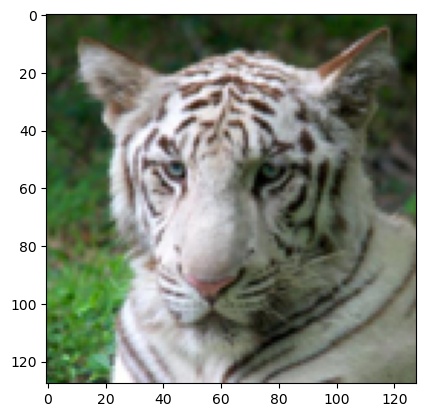

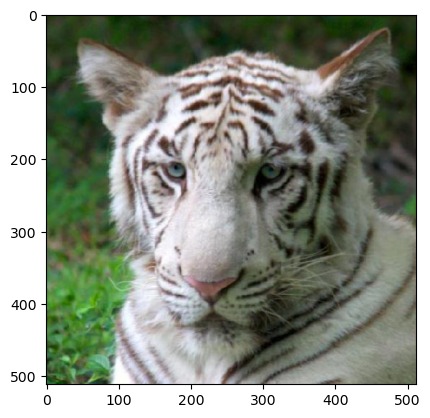

In [9]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
train_features.to(device)
train_labels.to(device)

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0].squeeze()

img = img.swapaxes(0, 1)
img = img.swapaxes(1, 2)
label = label.swapaxes(0, 1)
label = label.swapaxes(1, 2)

plt.imshow(img)
plt.show()
plt.imshow(label)
plt.show()

In [66]:
class Model(nn.Module):
    def __init__(self, scale_factor):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 3 * scale_factor ** 2, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(scale_factor)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.sigmoid(self.conv3(x))
        x = self.pixel_shuffle(x)
        return x


In [67]:
print('===> Building model')
model = Model(scale_factor=4).to(device)

===> Building model


In [68]:
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.003)


def train(epoch):
    epoch_loss = 0
    for iteration, batch in enumerate(train_dataloader, 1):
        img, target = batch[0].to(device), batch[1].to(device)

        optimizer.zero_grad()
        loss = criterion(model(img), target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

        print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(train_dataloader), loss.item()))

    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(train_dataloader)))

In [71]:
for i in range(5):
    train(i)

===> Epoch[0](1/75): Loss: 0.0095
===> Epoch[0](2/75): Loss: 0.0085
===> Epoch[0](3/75): Loss: 0.0089
===> Epoch[0](4/75): Loss: 0.0076
===> Epoch[0](5/75): Loss: 0.0082
===> Epoch[0](6/75): Loss: 0.0091
===> Epoch[0](7/75): Loss: 0.0087
===> Epoch[0](8/75): Loss: 0.0081
===> Epoch[0](9/75): Loss: 0.0089
===> Epoch[0](10/75): Loss: 0.0085
===> Epoch[0](11/75): Loss: 0.0089
===> Epoch[0](12/75): Loss: 0.0088
===> Epoch[0](13/75): Loss: 0.0082
===> Epoch[0](14/75): Loss: 0.0069
===> Epoch[0](15/75): Loss: 0.0080
===> Epoch[0](16/75): Loss: 0.0078
===> Epoch[0](17/75): Loss: 0.0081
===> Epoch[0](18/75): Loss: 0.0086
===> Epoch[0](19/75): Loss: 0.0084
===> Epoch[0](20/75): Loss: 0.0074
===> Epoch[0](21/75): Loss: 0.0079
===> Epoch[0](22/75): Loss: 0.0079
===> Epoch[0](23/75): Loss: 0.0082
===> Epoch[0](24/75): Loss: 0.0080
===> Epoch[0](25/75): Loss: 0.0070
===> Epoch[0](26/75): Loss: 0.0072
===> Epoch[0](27/75): Loss: 0.0071
===> Epoch[0](28/75): Loss: 0.0081
===> Epoch[0](29/75): Loss: 0

===> Epoch[3](8/75): Loss: 0.0049
===> Epoch[3](9/75): Loss: 0.0041
===> Epoch[3](10/75): Loss: 0.0046
===> Epoch[3](11/75): Loss: 0.0047
===> Epoch[3](12/75): Loss: 0.0049
===> Epoch[3](13/75): Loss: 0.0044
===> Epoch[3](14/75): Loss: 0.0040
===> Epoch[3](15/75): Loss: 0.0048
===> Epoch[3](16/75): Loss: 0.0043
===> Epoch[3](17/75): Loss: 0.0043
===> Epoch[3](18/75): Loss: 0.0044
===> Epoch[3](19/75): Loss: 0.0041
===> Epoch[3](20/75): Loss: 0.0055
===> Epoch[3](21/75): Loss: 0.0041
===> Epoch[3](22/75): Loss: 0.0046
===> Epoch[3](23/75): Loss: 0.0051
===> Epoch[3](24/75): Loss: 0.0051
===> Epoch[3](25/75): Loss: 0.0046
===> Epoch[3](26/75): Loss: 0.0045
===> Epoch[3](27/75): Loss: 0.0039
===> Epoch[3](28/75): Loss: 0.0050
===> Epoch[3](29/75): Loss: 0.0046
===> Epoch[3](30/75): Loss: 0.0047
===> Epoch[3](31/75): Loss: 0.0049
===> Epoch[3](32/75): Loss: 0.0042
===> Epoch[3](33/75): Loss: 0.0042
===> Epoch[3](34/75): Loss: 0.0043
===> Epoch[3](35/75): Loss: 0.0041
===> Epoch[3](36/75): 

In [33]:
model.parameters()

<generator object Module.parameters at 0x000001339A7B02E0>

In [36]:
from math import log10

def test():
    avg_psnr = 0
    with torch.no_grad():
        for batch in test_dataloader:
            input, target = batch[0].to(device), batch[1].to(device)

            prediction = model(input)
            mse = criterion(prediction, target)
            psnr = 10 * log10(1 / mse.item())
            avg_psnr += psnr
    print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(test_dataloader)))


In [42]:
device

device(type='cuda')

Feature batch shape: torch.Size([64, 3, 128, 128])
Labels batch shape: torch.Size([64, 3, 512, 512])
result batch shape: torch.Size([64, 3, 512, 512])
tensor(0.8055, grad_fn=<MaxBackward1>)
tensor([[0.4902, 0.5216, 0.4314],
        [0.4784, 0.5137, 0.4314],
        [0.4706, 0.5059, 0.4235],
        ...,
        [0.5333, 0.5961, 0.5529],
        [0.5373, 0.6000, 0.5569],
        [0.5412, 0.6039, 0.5608]])
[[0.41453406 0.53966665 0.4547289 ]
 [0.39924023 0.45892704 0.43988386]
 [0.4439625  0.48462194 0.44096172]
 ...
 [0.52321047 0.49203995 0.48177508]
 [0.49341613 0.48265302 0.48019528]
 [0.4832379  0.500586   0.52213615]]


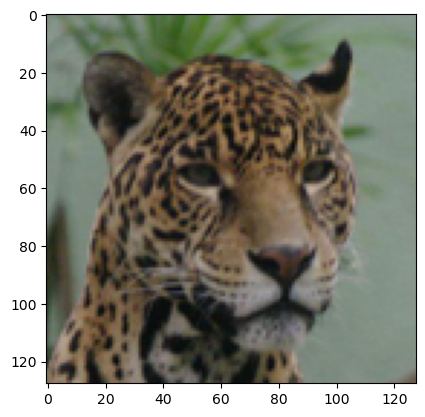

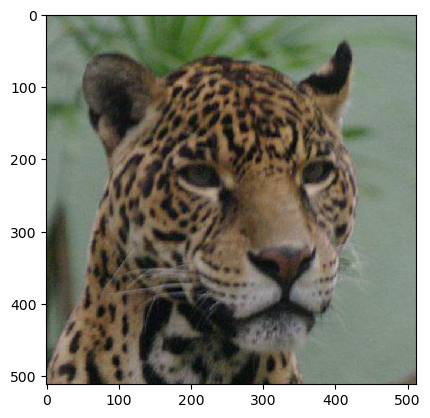

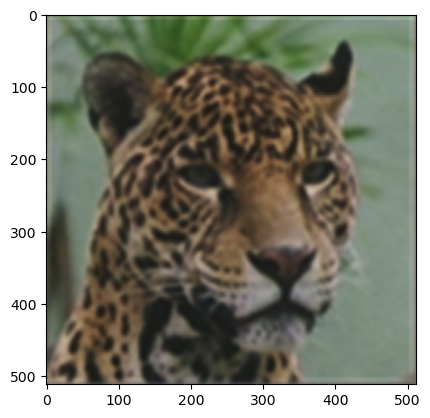

In [72]:
# Display image and label.
train_features, train_labels = next(iter(test_dataloader))

result = model(train_features.to(device))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
print(f"result batch shape: {result.size()}")
img = train_features[0].squeeze()
label = train_labels[0].squeeze()
result = result[0].squeeze().cpu()

print(torch.max(result))

img = img.swapaxes(0, 1)
img = img.swapaxes(1, 2)
label = label.swapaxes(0, 1)
label = label.swapaxes(1, 2)
result = result.swapaxes(0, 1)
result = result.swapaxes(1, 2)

result = result.detach().numpy()
print(label[0])
print(result[0])

plt.imshow(img)
plt.show()
plt.imshow(label)
plt.show()
plt.imshow(result)
plt.show()



In [64]:
torch.max(label)


TypeError: 'numpy.bool_' object is not iterable